In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy import stats
from neurodsp.filt import filter_signal
import os
from config import config_dict
import matplotlib.mlab as mlab
import pycircstat
import h5py

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

pd.options.display.max_columns=100

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/s2'):
    os.makedirs('figs/s2')

# Load shank and neuron dataframes

In [3]:
df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_shanks = df_shanks[df_shanks['burst_type']==0].reset_index()

df_neus = pd.read_csv(config_dict['processed_path'] + 'df_neus_stats.csv', index_col=0)
df_neus = df_neus[df_neus['N_spikes_burst0'] >= config_dict['analysis_N_spikes_min']]

# A. Plot example of spike-field coupling

In [4]:
# Determine recording to plot; neuron with high SFC
idx_plt = 705

# Load lfp
row = df_neus.loc[idx_plt]
elec = df_shanks[(df_shanks['sess']==row['sess']) &
                 (df_shanks['sh']==row['sh'])]['elec'].values[0]
Fs = df_shanks[(df_shanks['sess']==row['sess']) &
                 (df_shanks['sh']==row['sh'])]['Fs'].values[0]
lfp_filename = '{:s}{:s}/{:s}/{:d}/lfp{:d}.mat'.format(config_dict['mat_path'],
                                               row['rat'], row['sess'], row['sh'], elec)
f = h5py.File(lfp_filename)
lfp = np.array(f['lfp']).T[0]

# Broad bandpass filter LFP
lfp_filt = filter_signal(lfp, Fs, 'lowpass', fc=config_dict['cf_low'],
                         n_seconds=config_dict['N_seconds_low'], remove_edge_artifacts=False)
lfp_filt = filter_signal(lfp_filt, Fs, 'highpass', fc=config_dict['cf_high'],
                         n_seconds=config_dict['N_seconds_high'], remove_edge_artifacts=False)

# Load spiking data
f = np.load(config_dict['mat_path'] + row['rat'] + '/' + row['sess'] + '/neu_raster.npz')
raster_times = f['raster_times_by_shank'][int(row['sh'])]
raster_neus = f['raster_neus_by_shank'][int(row['sh'])]
spkt = raster_times[raster_neus == row['clu']]

Transition bandwidth is 2.4 Hz. Pass/stop bandwidth is 25 Hz
Transition bandwidth is 0.0 Hz. Pass/stop bandwidth is 624.0 Hz


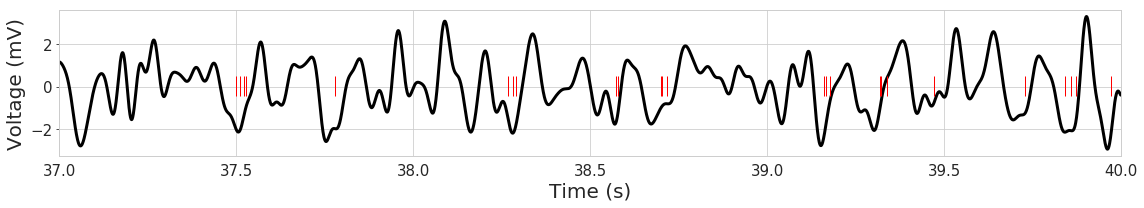

In [5]:
# Plot lfp and spikes for pre and post separate
tlims = (37, 40)
t = np.arange(0, len(lfp)/Fs, 1/Fs)
tidx = np.logical_and(t >= tlims[0], t < tlims[1])
spkt_plt = spkt[np.logical_and(spkt >= tlims[0]*Fs, spkt < tlims[1]*Fs)]

plt.figure(figsize=(16,3))
plt.plot(t[tidx], lfp_filt[tidx]/1000, 'k', linewidth=3)
plt.xticks(size=15)
plt.xlabel('Time (s)')
plt.yticks()
plt.ylabel('Voltage (mV)')
plt.xlim((tlims[0], tlims[1]))

# Find spikes in time range of interest
ax2 = plt.gca().twinx()
ax2.plot(t[spkt_plt], np.ones_like(spkt_plt)*.475, 'r|', ms=20)
ax2.set_yticks([])
ax2.set_ylim((0,1))
plt.tight_layout()
plt.savefig('figs/s2/A.png')

# B-C. Distribution of firing rates by cell type

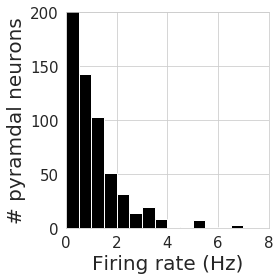

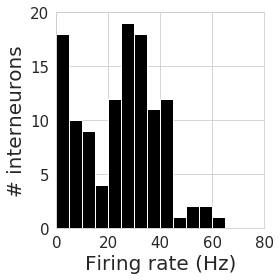

In [6]:
for neutype, neuname, letter, bins, yticks, xticks in zip(
    ['p', 'i'], ['pyramdal ', 'inter'], ['B', 'C'],
    [np.arange(0,8,.5), np.arange(0,80,5)],
    [np.arange(0, 201, 50), np.arange(0, 21, 5)],
    [np.arange(0, 9, 2), np.arange(0, 81, 20)]):
    plt.figure(figsize=(4,4))
    plt.hist(df_neus[df_neus['type']==neutype]['fr_burst0'],
             bins=bins, color='k');
    plt.xlabel('Firing rate (Hz)')
    plt.ylabel('# {:s}neurons'.format(neuname))
    plt.yticks(yticks)
    plt.xticks(xticks)
    plt.xlim((xticks[0], xticks[-1]))
    plt.ylim((yticks[0], yticks[-1]))

    plt.tight_layout()
    plt.savefig('figs/s2/{:s}.png'.format(letter))

# D-E. Distribution of SFC magnitude and phase

p mean vec pha = -0.77pi, mag = 0.11, p = 2.662702E-119


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/matplotlib/projections/polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


i mean vec pha = 0.85pi, mag = 0.14, p = 3.980395E-15


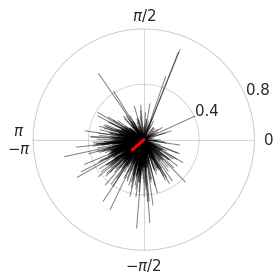

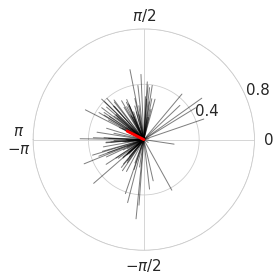

In [7]:
for t, letter in zip(['p', 'i'], ['D', 'E']):
    df_plt = df_neus[df_neus['type']==t]
    
    plt.figure(figsize=(4,4))
    ax = plt.subplot(111, polar=True)

    for i, row in df_plt.iterrows():
        mag_end = row['sfc_magnitude_cycles']
        pha_end = row['sfc_phase_cycles']

        # Plot the line
        plt.plot(np.linspace(pha_end, pha_end, 2),
                 np.linspace(0, mag_end, 2), 'k', alpha=.5, linewidth=1)

    # Compute and plot mean vector
    mean_vec = np.mean(df_plt['sfc_magnitude_cycles'] * np.exp(1j*df_plt['sfc_phase_cycles']))
    plt.plot(np.linspace(np.angle(mean_vec), np.angle(mean_vec), 2),
             np.linspace(0, np.abs(mean_vec), 2), 'r', linewidth=3)
    
    # Compute stats
    angles = np.angle(df_plt['sfc_magnitude_cycles'] * np.exp(1j*df_plt['sfc_phase_cycles']))
    angles = angles[~np.isnan(angles)]
    p, z = pycircstat.tests.rayleigh(angles)
    print(t, 'mean vec pha = {:.2f}pi, mag = {:.2f}, p = {:0E}'.format(np.angle(mean_vec)/np.pi,
                                                                       np.abs(mean_vec), p))
    
    # Format the plot    
    plt.yticks([.4,.8])
    plt.xticks(np.arange(-np.pi,np.pi,np.pi/2),['$\pi$\n$-\pi$','$-\pi/2$',0,'$\pi/2$'])
    plt.ylim((0,.8))
    ax.set_thetalim(-np.pi, np.pi)
    
    plt.tight_layout()
    plt.savefig('figs/s2/{:s}.png'.format(letter))

### SFC preferred phase does not seem to correlate with firing rate

In [8]:
for t in ['i', 'p']:
    df_plt = df_neus[df_neus['type']==t]
    df_plt.dropna(subset=['sfc_phase_cycles_2pi', 'sfc_phase_cycles'], inplace=True)
    print(t, stats.spearmanr(df_plt['fr_burst0'], df_plt['sfc_phase_cycles_2pi']))
    print(t, stats.spearmanr(df_plt['fr_burst0'], df_plt['sfc_phase_cycles']))

i SpearmanrResult(correlation=-0.051794616151545375, pvalue=0.5758721305592345)
i SpearmanrResult(correlation=0.1278664007976072, pvalue=0.165798725125156)
p SpearmanrResult(correlation=0.06260560033250213, pvalue=0.08477469698234785)
p SpearmanrResult(correlation=0.06220982196567054, pvalue=0.08676550470659301)


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
